Stifler density over k-core

In [37]:
import csv

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from collections import Counter
from operator import itemgetter
from os import listdir
from os.path import isfile, isdir, join, exists

In [38]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['patch.force_edgecolor'] = True

In [39]:
mypath = '../../log/EmailURV2'
dirs = [f for f in listdir(mypath) if isdir(join(mypath,f))]
kcores = [join(join(mypath, f),'k_core.csv') for f in dirs]
N_AGENTS = 1133
kcores

['../../log/EmailURV2/2019_19_01_17_44_09/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_52_04/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_41_35/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_40_16/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_50_41/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_34_59/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_46_51/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_42_54/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_48_09/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_36_17/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_37_37/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_45_32/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_33_33/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_49_25/k_core.csv',
 '../../log/EmailURV2/2019_19_01_17_38_55/k_core.csv']

read all files. skip intestation rows, create an array of raw data, [k-core, stifler-density]

In [40]:
#s_rawdensities = []
#i_rawdensities = []
#r_rawdensities = []
rawdensities = []
for index, filename in enumerate(kcores):
    s_den = 0
    i_den = 0
    r_den = 0
    k_core = 0
    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter=",")
        for row in reader:
            if len(row) < 4:
                continue
            try:
                int(row[0])
            except:
                continue
            if int(row[0]) == 1 and row[3] == 'i':
                k_core = int(row[2])
            if int(row[0]) != 1:
                if row[3] == 's':
                    s_den += 1
                elif row[3] == 'i':
                    i_den += 1
                elif row[3] == 'r':
                    r_den += 1
                else:
                    print("unrecognized option", row[3])
    total = s_den +i_den + r_den
    s_den /= total
    i_den /= total
    r_den /= total
    #s_rawdensities.append([k_core, s_den])
    #i_rawdensities.append([k_core, i_den])
    #r_rawdensities.append([k_core, r_den])
    rawdensities.append([k_core, s_den, i_den, r_den])

#s_rawdensities = np.array(s_rawdensities)
#i_rawdensities = np.array(i_rawdensities)
#r_rawdensities = np.array(r_rawdensities)


# clean spreading that failed
rawdensities = [el for el in rawdensities if el[1] < 0.99]
rawdensities = np.array(rawdensities)


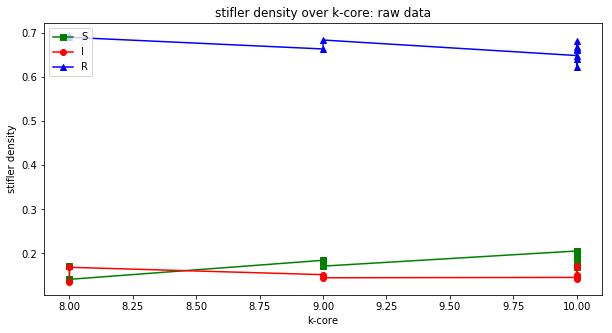

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# sort by k-core
#s_rawdensities = np.array(sorted(s_rawdensities, key=itemgetter(0)))
#i_rawdensities = np.array(sorted(i_rawdensities, key=itemgetter(0)))
#r_rawdensities = np.array(sorted(r_rawdensities, key=itemgetter(0)))
rawdensities = np.array(sorted(rawdensities, key=itemgetter(0)))
k, s, i, r = rawdensities.T
#s_x, s_y = s_rawdensities.T
#i_x, i_y = i_rawdensities.T
#r_x, r_y = r_rawdensities.T

#s_x, s_y = (list(x) for x in zip(*sorted(zip(s_x, s_y), key=lambda pair: pair[0])))
#i_x, i_y = (list(x) for x in zip(*sorted(zip(i_x, i_y), key=lambda pair: pair[0])))
#r_x, r_y = (list(x) for x in zip(*sorted(zip(r_x, r_y), key=lambda pair: pair[0])))

ax1.plot(k, s, 'sg-', label='S')
ax1.plot(k, i, 'or-', label='I')
ax1.plot(k, r, '^b-', label='R')

plt.legend(loc='upper left')
plt.title("stifler density over k-core: raw data")
plt.ylabel("stifler density")
plt.xlabel("k-core")
plt.show()

Text(0.5, 0, 'k-core')

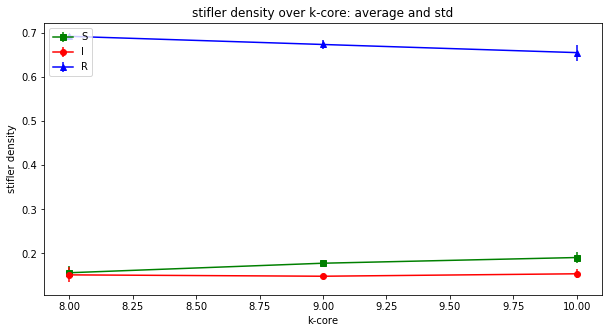

In [42]:
cleanlist = []
s_sublist = []
i_sublist = []
r_sublist = []

for i in range(int(max([el[0] for el in np.sort(rawdensities, axis=0)])) + 1):
    s_sublist = [el[1] for el in rawdensities if int(el[0]) == i ]
    i_sublist = [el[2] for el in rawdensities if int(el[0]) == i ]
    r_sublist = [el[3] for el in rawdensities if int(el[0]) == i ]
    cleanlist.append([
        i,
        np.mean(s_sublist),
        np.std(s_sublist),
        np.mean(i_sublist),
        np.std(i_sublist),
        np.mean(r_sublist),
        np.std(r_sublist)
    ])
    s_sublist = []
    i_sublist = []
    r_sublist = []

fig = plt.figure()
ax2 = fig.add_subplot(111)

k_m, s_m, s_s, i_m, i_s, r_m, r_s = np.array([el for el in cleanlist if ~np.isnan(el[1])]).T

ax2.errorbar(k_m, s_m, yerr=s_s, fmt='gs-', label='S')
ax2.errorbar(k_m, i_m, yerr=i_s, fmt='ro-', label='I')
ax2.errorbar(k_m, r_m, yerr=r_s, fmt='b^-', label='R')

plt.legend(loc='upper left')
plt.title("stifler density over k-core: average and std")
plt.ylabel("stifler density")
plt.xlabel("k-core")